# MUSIC GENRE DETECTION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import IPython.display as ipd
import warnings
import os
import re
warnings.filterwarnings('ignore')

In [4]:
print(list(os.listdir(".\\Dataset\\Data\\genres_original")))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
blues_song_path ='../Dataset/Data/genres_original/blues/blues.00003.wav'
blues_sound, blues_sr =  librosa.load(blues_song_path)

classical_song_path='../Dataset/Data/genres_original/classical/classical.00003.wav'
classical_sound, classical_sr =  librosa.load(classical_song_path)

country_song_path='../Dataset/Data/genres_original/country/country.00000.wav'
country_sound, country_sr =  librosa.load(country_song_path)

disco_song_path='../Dataset/Data/genres_original/disco/disco.00000.wav'
disco_sound, disco_sr =  librosa.load(disco_song_path)

hiphop_song_path='../Dataset/Data/genres_original/hiphop/hiphop.00003.wav'
hiphop_sound, hiphop_sr =  librosa.load(hiphop_song_path)

jazz_song_path='../Dataset/Data/genres_original/jazz/jazz.00003.wav'
jazz_sound, jazz_sr =  librosa.load(jazz_song_path)

metal_song_path='../Dataset/Data/genres_original/metal/metal.00003.wav'
metal_sound, metal_sr =  librosa.load(metal_song_path)

pop_song_path='../Dataset/Data/genres_original/pop/pop.00003.wav'
pop_sound, pop_sr =  librosa.load(pop_song_path)

reggae_song_path='../Dataset/Data/genres_original/reggae/reggae.00003.wav'
reggae_sound, reggae_sr =  librosa.load(reggae_song_path)

rock_song_path='../Dataset/Data/genres_original/rock/rock.00003.wav'
rock_sound, rock_sr =  librosa.load(rock_song_path)


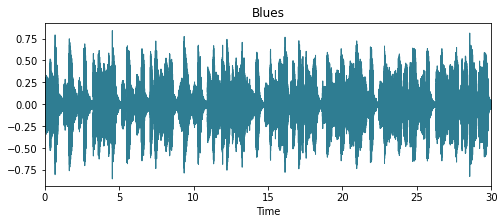

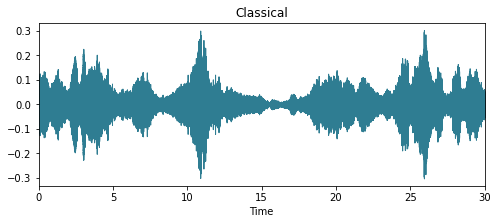

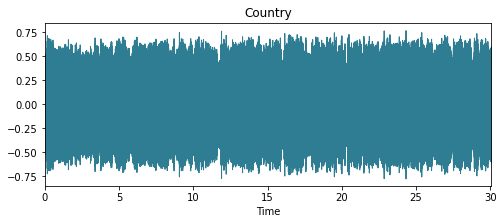

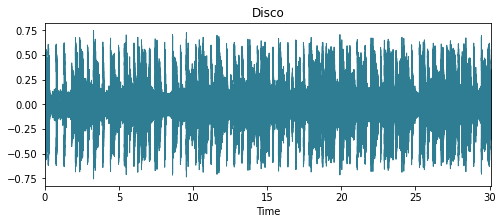

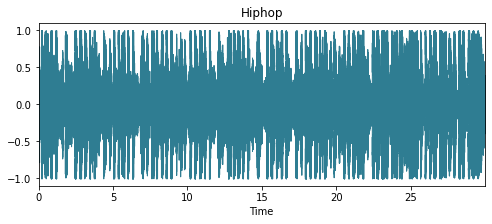

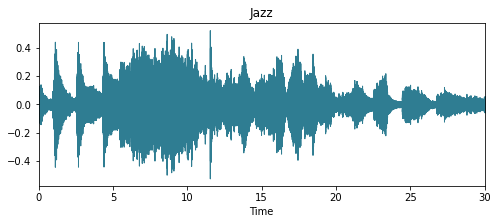

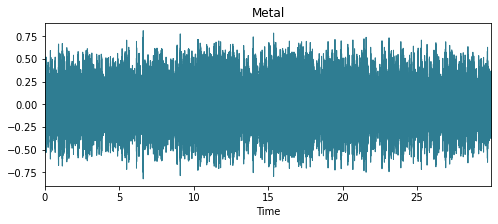

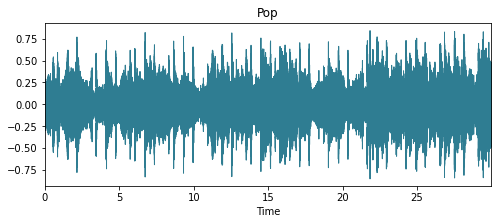

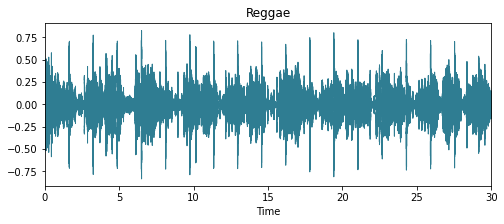

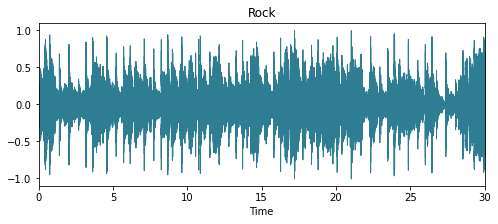

In [6]:
plt.figure(figsize=(8, 3))
plt.title("Blues")
librosa.display.waveplot(y=blues_sound, sr=blues_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Classical")
librosa.display.waveplot(y=classical_sound, sr=classical_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Country")
librosa.display.waveplot(y=country_sound, sr=country_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Disco")
librosa.display.waveplot(y=disco_sound, sr=disco_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Hiphop")
librosa.display.waveplot(y=hiphop_sound, sr=hiphop_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Jazz")
librosa.display.waveplot(y=jazz_sound, sr=jazz_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Metal")
librosa.display.waveplot(y=metal_sound, sr=metal_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Pop")
librosa.display.waveplot(y=pop_sound, sr=pop_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Reggae")
librosa.display.waveplot(y=reggae_sound, sr=reggae_sr, color="#2f7d92ff")
plt.show()

plt.figure(figsize=(8, 3))
plt.title("Rock")
librosa.display.waveplot(y=rock_sound, sr=rock_sr, color="#2f7d92ff")
plt.show()

In [6]:
hop_length = 5000
j=0
data=[]
dataset_path = ".\\Dataset\\Data\\genres_original"
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\Dataset\\Data\\genres_original")):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path)
                zero_crossings = librosa.zero_crossings(signal, pad=False)
                data.append([re.split(r'[_.]', f)[0],f,sum(zero_crossings)])


KeyboardInterrupt: 

In [9]:
df = pd.DataFrame(data)
df

,0,1,2
0,blues,blues.00000.wav,55031
1,blues,blues.00001.wav,37139
2,blues,blues.00002.wav,50563
3,blues,blues.00003.wav,22077
4,blues,blues.00004.wav,67225
...,...,...,...
994,rock,rock.00095.wav,59124
995,rock,rock.00096.wav,64737
996,rock,rock.00097.wav,80747
997,rock,rock.00098.wav,32292


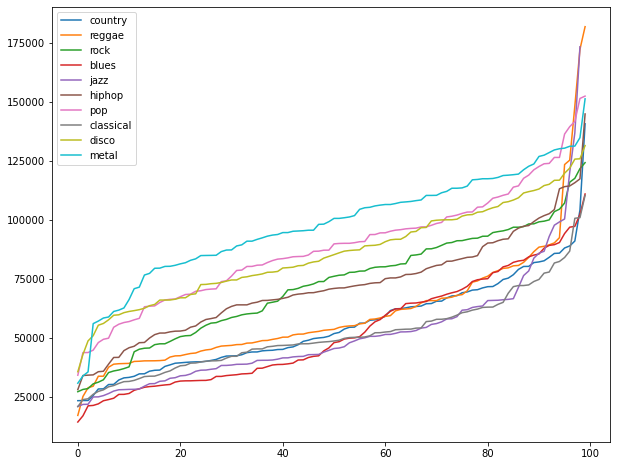

In [10]:
df = df.sort_values(by=[2])
set1 = set(df[0])
plt.figure(figsize=(10,8))
for count in set1:
     selected_data = df.loc[df[0] == count]
     plt.plot(np.linspace(0, len(selected_data), len(selected_data), endpoint=False), selected_data[2], label=count)
     
plt.legend()
plt.show()

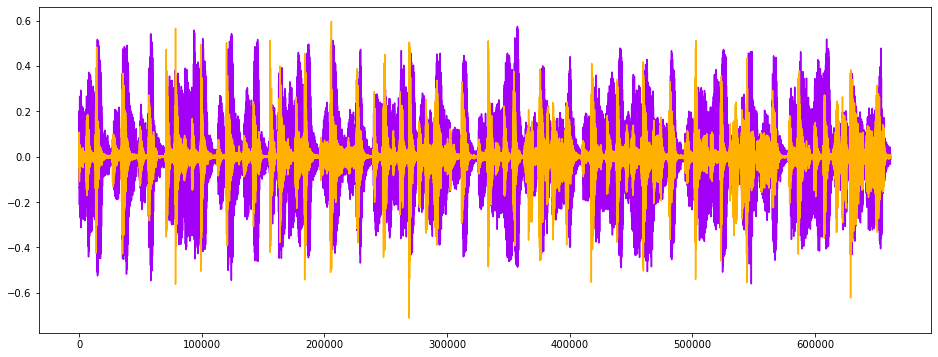

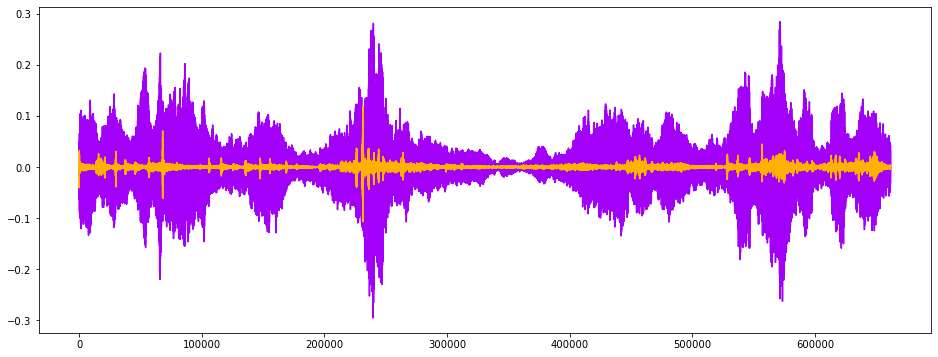

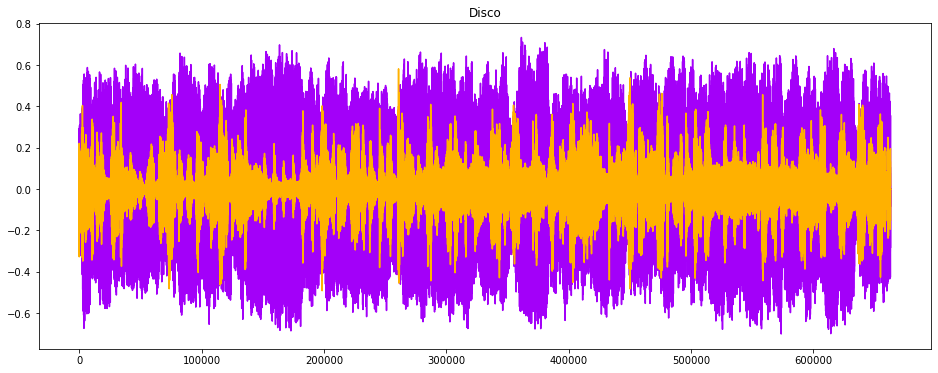

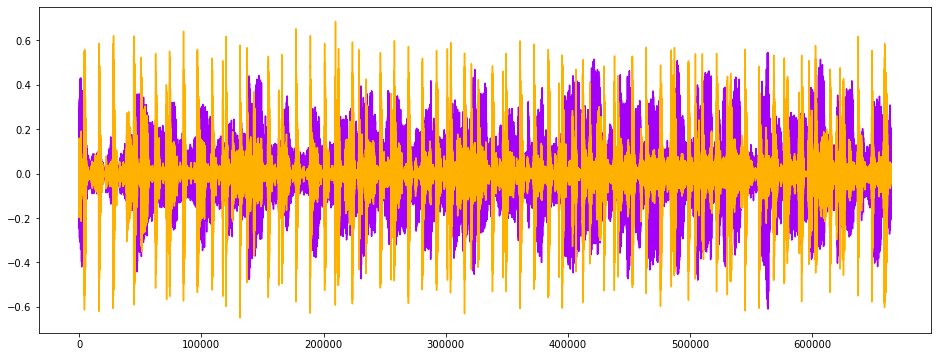

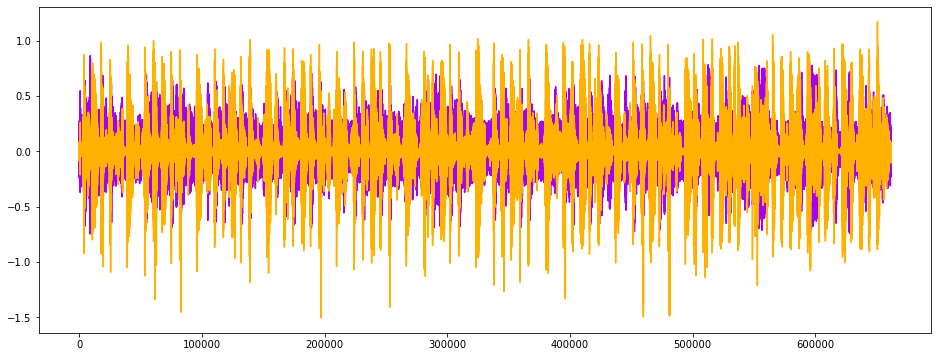

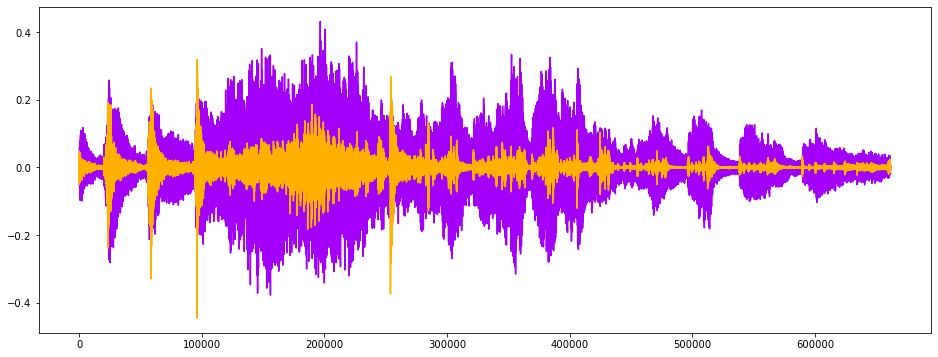

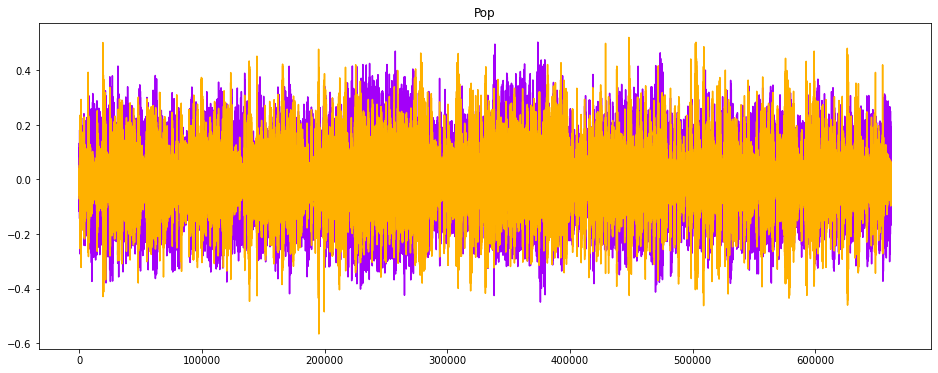

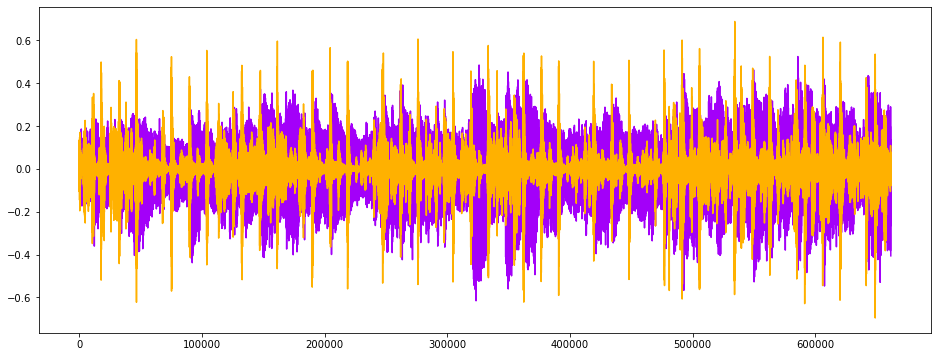

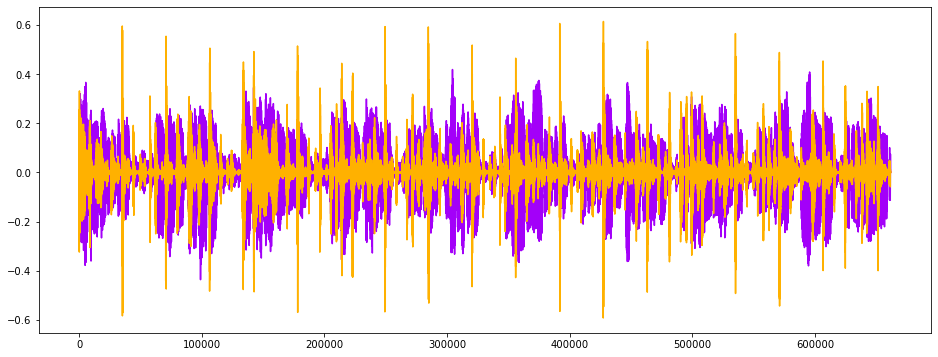

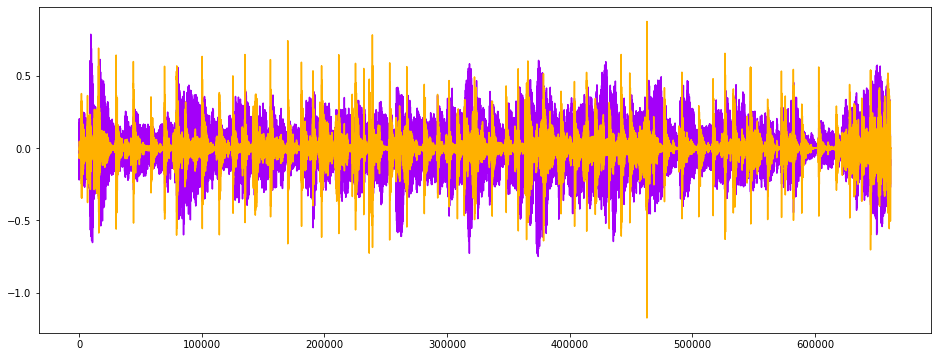

In [21]:
y_harm, y_perc = librosa.effects.hpss(blues_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(classical_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(country_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(disco_sound)
plt.title("Disco")
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(hiphop_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(jazz_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(metal_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(pop_sound)
plt.title("Pop")
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(reggae_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

y_harm, y_perc = librosa.effects.hpss(rock_sound)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

Mean: -8.8508056e-10 

Var: 1.0000001


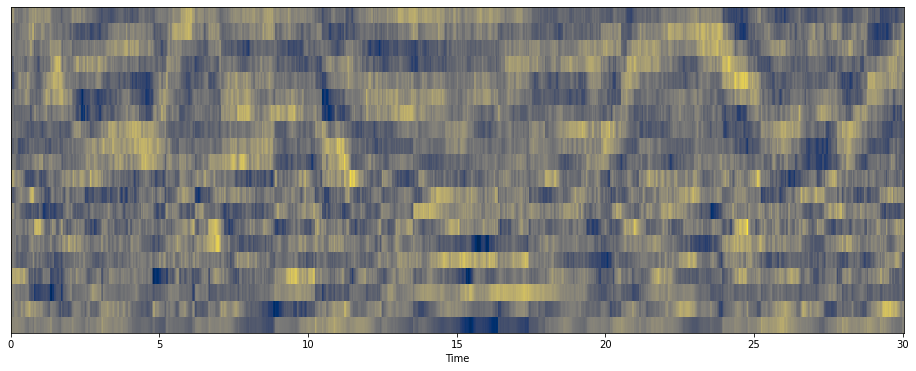

In [15]:
mfccs = librosa.feature.mfcc(classical_sound, sr=sr)
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cividis');

# Feature Extraction

In [ ]:
import os 
path =".\\three_second_songs"
try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)  

In [10]:
from pydub import AudioSegment
hop_length = 5000
j=0
data=[]
dataset_path = ".\\Dataset\\Data\\genres_original"
three_second_folder = ".\\three_second_songs"
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                for i in range(0,29,3):
                    t1 = i * 1000 
                    t2 = (i+3)* 1000
                    newAudio = AudioSegment.from_wav(file_path)
                    newAudio = newAudio[t1:t2]
                    split_fn = three_second_folder +"\\" + str(i)+'_'+f 
                    newAudio.export(split_fn, format="wav")

KeyboardInterrupt: 

In [ ]:
data=[]
df = pd.DataFrame(data, columns = ['filename','chromagram_mean','chromagram_var','rms_mean','rms_var','spectral_centroid_mean','spectral_centroid_var','spectral_bandwidth_mean','spectral_bandwidth_var','spectral_rolloff_mean','spectral_rolloff_var','zero_crossing_rate_mean','zero_crossing_rate_var','tempo_mean','y_harm_mean','y_perc_mean','y_harm_var','y_perc_var','mfccm_1','mfccm_2','mfccm_3','mfccm_4','mfccm_5','mfccm_6','mfccm_7','mfccm_8','mfccm_9','mfccm_10','mfccm_11','mfccm_12','mfccm_13','mfccm_14','mfccm_15','mfccm_16','mfccm_17','mfccm_18','mfccm_19','mfccm_20','mfccv_1','mfccv_2','mfccv_3','mfccv_4','mfccv_5','mfccv_6','mfccv_7','mfccv_8','mfccv_9','mfccv_10','mfccv_11','mfccv_12','mfccv_13','mfccv_14','mfccv_15','mfccv_16','mfccv_17','mfccv_18','mfccv_19','mfccv_20'])
df

In [24]:
hop_length = 5000
j=0
data=[]
mfcc_mean=[]
mfcc_var=[]
import csv
import re
header = ['filename','chromagram_mean','chromagram_var','rms_mean','rms_var','spectral_centroid_mean','spectral_centroid_var','spectral_bandwidth_mean','spectral_bandwidth_var','spectral_rolloff_mean','spectral_rolloff_var','zero_crossing_rate_mean','zero_crossing_rate_var','tempo_mean','y_harm_mean','y_perc_mean','y_harm_var','y_perc_var','mfccm_1','mfccm_2','mfccm_3','mfccm_4','mfccm_5','mfccm_6','mfccm_7','mfccm_8','mfccm_9','mfccm_10','mfccm_11','mfccm_12','mfccm_13','mfccm_14','mfccm_15','mfccm_16','mfccm_17','mfccm_18','mfccm_19','mfccm_20','mfccv_1','mfccv_2','mfccv_3','mfccv_4','mfccv_5','mfccv_6','mfccv_7','mfccv_8','mfccv_9','mfccv_10','mfccv_11','mfccv_12','mfccv_13','mfccv_14','mfccv_15','mfccv_16','mfccv_17','mfccv_18','mfccv_19','mfccv_20']
file = open('.\\Dataset\\data_f2.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
dataset_path = ".\\three_second_songs"
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\three_second_songs")):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path)
                chromagram =librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length)
                rms =librosa.feature.rms(y=signal, hop_length=hop_length)
                spectral_centroid =librosa.feature.spectral_centroid(y=signal, sr=sr,hop_length=hop_length)
                spectral_bandwidth=librosa.feature.spectral_bandwidth(y=signal, sr=sr,hop_length=hop_length)
                spectral_rolloff=librosa.feature.spectral_rolloff(y=signal, sr=sr,hop_length=hop_length)
                zero_crossing_rate=librosa.feature.zero_crossing_rate(y=signal,hop_length=hop_length)
                tempo = librosa.beat.tempo(y=signal)
                y_harm, y_perc = librosa.effects.hpss(signal)
                mfcc = librosa.feature.mfcc(y=signal,hop_length=hop_length)
                mfccm=mfcc.mean(axis=1)
                mfccv=mfcc.var(axis=1)
                
                data=[re.split(r'[_.]', f)[1],np.mean(chromagram),np.var(chromagram),np.mean(rms),np.var(rms),np.mean(spectral_centroid),
                             np.var(spectral_centroid),np.mean(spectral_bandwidth),np.var(spectral_bandwidth),np.mean(spectral_rolloff),
                             np.var(spectral_rolloff),np.mean(zero_crossing_rate),np.var(zero_crossing_rate),tempo,
                             np.mean(y_harm),np.mean(y_perc),np.var(y_harm),np.var(y_perc)]+ mfccm.tolist()+mfccv.tolist()
                file = open('.\\Dataset\\data_f2.csv', 'a', newline='')
                
                with file:
                    writer = csv.writer(file)
                    writer.writerow(data)
            

# XGBoost

In [25]:
data = pd.read_csv('.\\Dataset\\data_f2.csv') 
data.head()

,filename,chromagram_mean,chromagram_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,spectral_rolloff_mean,...,mfccv_11,mfccv_12,mfccv_13,mfccv_14,mfccv_15,mfccv_16,mfccv_17,mfccv_18,mfccv_19,mfccv_20
0,blues,0.309772,0.086180,0.122332,0.003996,1905.864620,372848.493529,2039.903690,148552.850288,3852.136230,...,63.524784,63.593975,45.755207,27.769102,42.942097,31.999884,38.952271,35.650867,38.750572,54.054966
1,blues,0.387467,0.088444,0.090634,0.004472,1441.794421,477486.108919,2012.091248,169084.665401,3373.791504,...,58.737957,100.303261,42.518818,54.139900,17.740961,34.436615,11.788865,16.438757,23.103626,24.171551
2,blues,0.342333,0.088451,0.164507,0.001718,1590.631493,106273.817134,1779.440111,57259.287100,3183.068848,...,38.177883,74.012764,29.570007,28.609316,31.235901,40.570187,60.971497,67.375412,46.838737,18.706514
3,blues,0.352511,0.095242,0.139052,0.008554,861.180590,45696.782190,1368.800379,45561.704247,1644.982910,...,18.289917,4.868769,15.948905,24.647282,16.995655,14.326455,23.700819,24.284536,20.634005,42.395073
4,blues,0.313871,0.093442,0.083485,0.000430,1538.491099,90276.969412,1582.165228,27203.154354,2903.137207,...,24.151951,64.879745,131.285553,98.364815,76.809891,70.925453,69.762062,34.877029,39.460796,71.013603


In [26]:
y = data['filename']
X = data.loc[:, data.columns != 'filename']

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

X

,chromagram_mean,chromagram_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,spectral_rolloff_mean,spectral_rolloff_var,...,mfccv_11,mfccv_12,mfccv_13,mfccv_14,mfccv_15,mfccv_16,mfccv_17,mfccv_18,mfccv_19,mfccv_20
0,0.332515,0.600432,0.277464,0.103845,0.296336,0.070043,0.484431,0.127655,0.362783,0.097657,...,0.092592,0.107378,0.061823,0.022648,0.059096,0.039474,0.074981,0.056987,0.027692,0.055925
1,0.445626,0.619693,0.204973,0.116208,0.203546,0.089746,0.476106,0.145401,0.310196,0.212520,...,0.085482,0.171912,0.056959,0.046534,0.023289,0.042520,0.021644,0.022785,0.015253,0.024840
2,0.379918,0.619760,0.373910,0.044643,0.233306,0.019850,0.406465,0.048751,0.289229,0.057112,...,0.054941,0.125694,0.037497,0.023409,0.042464,0.050188,0.118217,0.113465,0.034122,0.019156
3,0.394735,0.677536,0.315699,0.222309,0.087453,0.008444,0.283545,0.038640,0.120139,0.019624,...,0.025398,0.004141,0.017025,0.019820,0.022230,0.017379,0.045034,0.036752,0.013290,0.043796
4,0.338483,0.662222,0.188627,0.011169,0.222880,0.016838,0.347413,0.022773,0.258455,0.041270,...,0.034106,0.109638,0.190372,0.086591,0.107217,0.088137,0.135478,0.055610,0.028257,0.073565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.343000,0.498799,0.169389,0.003365,0.243453,0.018087,0.456038,0.058697,0.340210,0.055967,...,0.080597,0.065726,0.040414,0.020662,0.087445,0.037416,0.044725,0.037189,0.008144,0.052900
9986,0.444706,0.466164,0.183337,0.004655,0.324910,0.014595,0.501899,0.025037,0.393473,0.028743,...,0.029402,0.032602,0.054363,0.020293,0.036520,0.035706,0.040024,0.044230,0.033057,0.021081
9987,0.488300,0.510223,0.158860,0.003307,0.336307,0.027356,0.467270,0.035378,0.398039,0.037827,...,0.084275,0.079385,0.029821,0.049555,0.073651,0.043600,0.055357,0.034434,0.016696,0.024678
9988,0.414832,0.730162,0.235879,0.003346,0.272972,0.047808,0.503177,0.086155,0.378086,0.091374,...,0.064881,0.051160,0.059920,0.054094,0.080313,0.025270,0.095936,0.073572,0.019196,0.041206


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
from sklearn.metrics import classification_report
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Accuracy', title, ':', accuracy_score(y_test, preds))
    print('Precision', title, ':', precision_score(y_test, preds,average='weighted'))
    print('Recall', title, ':', recall_score(y_test, preds,average='weighted'))
    print('F1', title, ':', f1_score(y_test, preds,average='weighted'))
    target_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    print(classification_report(y_test, preds, target_names=target_names))  

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
import warnings
warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")


xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

Accuracy Decission trees : 0.6176176176176176
Precision Decission trees : 0.6216656074509326
Recall Decission trees : 0.6176176176176176
F1 Decission trees : 0.6189953098726539
              precision    recall  f1-score   support

       blues       0.65      0.63      0.64       333
   classical       0.84      0.87      0.85       291
     country       0.45      0.49      0.47       294
       disco       0.48      0.50      0.49       292
      hiphop       0.64      0.56      0.60       320
        jazz       0.68      0.68      0.68       298
       metal       0.75      0.75      0.75       296
         pop       0.72      0.66      0.69       315
      reggae       0.53      0.56      0.55       286
        rock       0.44      0.47      0.46       272

    accuracy                           0.62      2997
   macro avg       0.62      0.62      0.62      2997
weighted avg       0.62      0.62      0.62      2997

[04:43:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 

[04:50:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.80647 



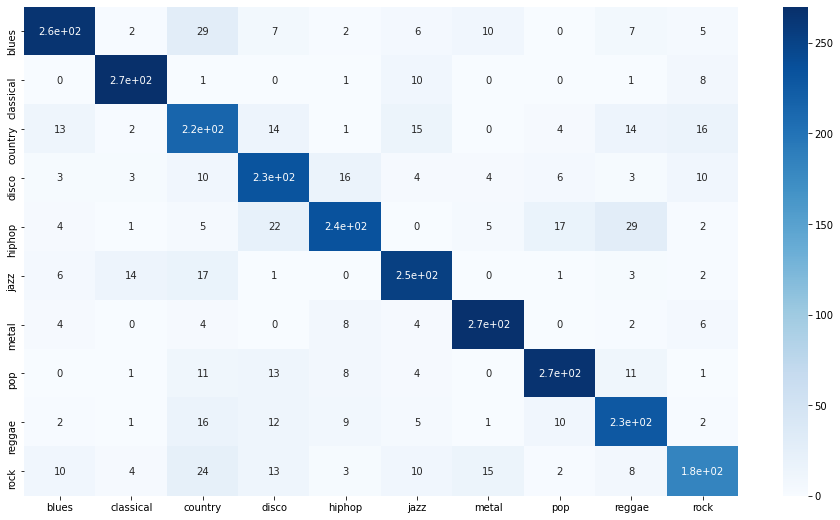

In [31]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.005)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

confusion_matr = confusion_matrix(y_test, preds) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

[05:02:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.87321 



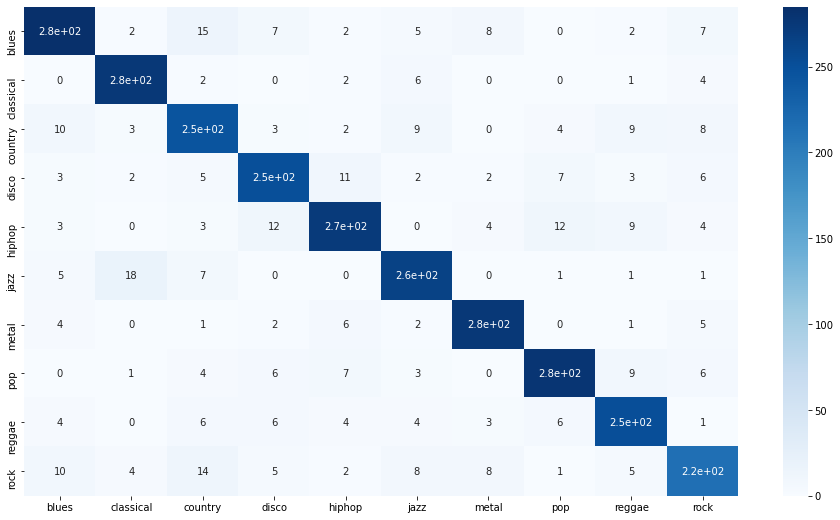

In [32]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

confusion_matr = confusion_matrix(y_test, preds) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

[05:10:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.81081 



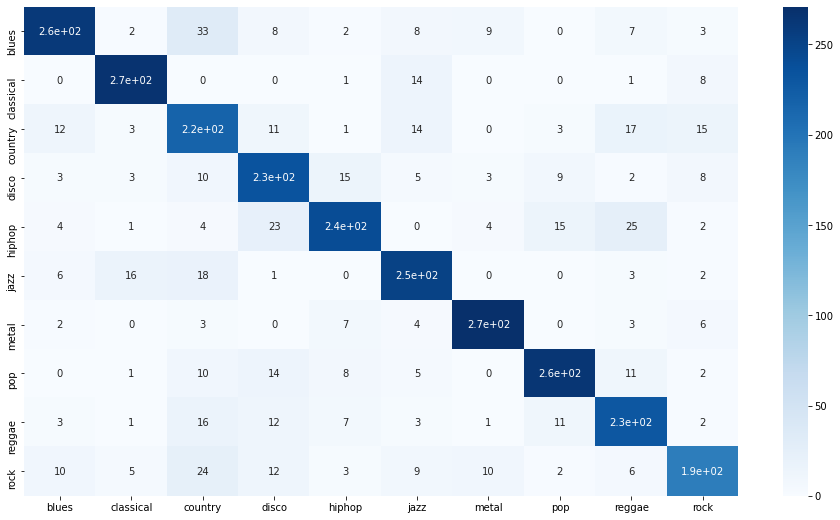

In [33]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

confusion_matr = confusion_matrix(y_test, preds) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

[05:11:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.86687 



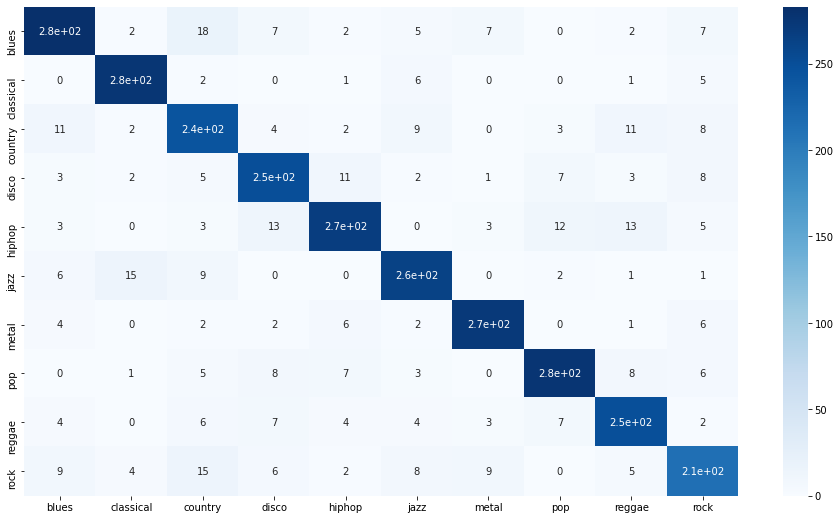

In [34]:
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

confusion_matr = confusion_matrix(y_test, preds) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

[05:16:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.84251 



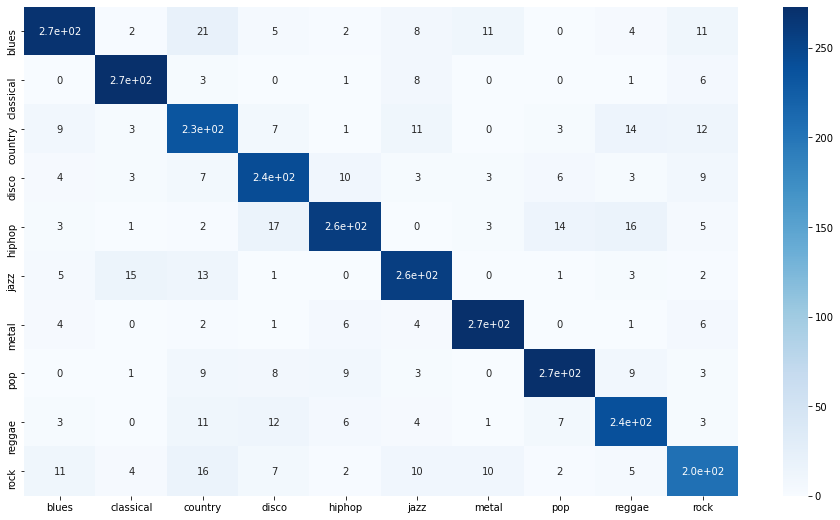

In [35]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

confusion_matr = confusion_matrix(y_test, preds) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

# CNN

In [8]:
dataset_path = ".\\three_second_songs"
data=[]
y=[]
hop_length = 5000
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(".\\three_second_songs")):
     if dirpath is not dataset_path:
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path)
                mfcc = librosa.feature.mfcc(y=signal,sr=sr)
                if(mfcc.shape[1]==130 and mfcc.shape[0]==20):
                    data.append(mfcc.T)
                    semantic_label = file_path.split("\\")[-1]
                    y.append(re.split(r'[_.]', semantic_label)[1])    

In [9]:
data=np.c_[data]
data.shape

In [11]:
temp_data=data

In [12]:
mydict={}
i = 0
for item in y:
    if(i>=0 and item in mydict):
        continue
    else:    
       i = i+1
       mydict[item] = i-1
k=[]
for item in y:
    k.append(mydict[item])
y=np.array(y)

In [13]:
y=np.array(k)
y

array([0, 0, 0, ..., 9, 9, 9])

In [15]:
import tensorflow.keras as keras

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")


    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def build_model(input_shape):

    model = keras.Sequential()


    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    X = X[np.newaxis, ...] 

  
    prediction = model.predict(X)

   
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
     
  
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)
    
    
    




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 18, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 9, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 9, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 7, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 4, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 4, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 3, 32)         4

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 3s - loss: 0.8260 - accuracy: 0.7165

Test accuracy: 0.7164597511291504


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 18, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 9, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 9, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 7, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 4, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 4, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 3, 32)         4

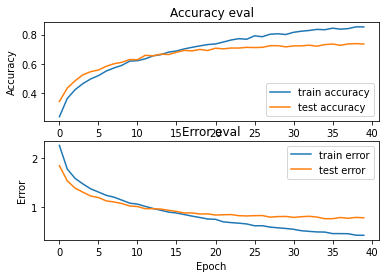

In [17]:
 plot_history(history)
    

In [18]:
import random
testing=random.randint(0,100)
X_to_predict = X_test[testing]
y_to_predict = y_test[testing]

predict(model, X_to_predict, y_to_predict)

Target: 2, Predicted label: [2]


In [19]:
predict(model, X_to_predict, y_to_predict)

Target: 2, Predicted label: [2]
